In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms
from torchvision.utils import save_image, make_grid
import os
import numpy as np
from tqdm import tqdm
from PIL import Image
import pandas as pd

In [ ]:
import logging

logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

# Load Dataset

In [ ]:
img_size = 128

transform = transforms.Compose([
    transforms.Resize((img_size, img_size)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  
])

dataset = datasets.CelebA(root='celeba/', split="train", target_type='attr', download=True, transform=transform)
train_dataloader = DataLoader(dataset, batch_size=32, shuffle=True, num_workers=4)

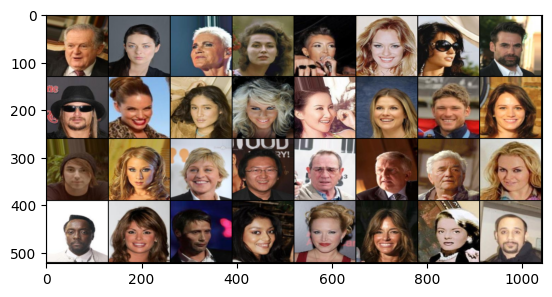

In [4]:
from matplotlib import pyplot as plt
x, y = next(iter(train_dataloader))

grid = make_grid(x, normalize=True, scale_each=False)
plt.imshow(grid.permute(1, 2, 0).numpy())

# Conditional Model w/ Diffusers

In [15]:
from diffusers import DDPMScheduler, UNet2DModel

device = "cuda" if torch.cuda.is_available() else "cpu"

logging.info("Using device: {}".format(device))

class ClassConditionedUnet(nn.Module):
    def __init__(self, class_attr_dim=40, class_emb_size=5, img_size=128):
        super().__init__()
        
        self.class_emb = nn.Linear(class_attr_dim, class_emb_size)
        
        self.model = UNet2DModel(
            sample_size=img_size, # Image resolution
            in_channels=3+class_emb_size,
            out_channels=3,
            layers_per_block=2,
            block_out_channels=(64, 128, 256, 512),
            down_block_types=(
                "DownBlock2D",        # a regular ResNet downsampling block
                "AttnDownBlock2D",    # a ResNet downsampling block with spatial self-attention
                "AttnDownBlock2D",
                "AttnDownBlock2D"
            ),
            up_block_types=(
                "AttnUpBlock2D",
                "AttnUpBlock2D",      # a ResNet upsampling block with spatial self-attention
                "AttnUpBlock2D",      # a ResNet upsampling block with spatial self-attention
                "UpBlock2D",          # a regular ResNet upsampling block
            ),
        )
        
    def forward(self, x, t, class_attr):
        bs, ch, w, h = x.shape
        
        logging.info(f"X: {x.device}, t: {t.device}, class_attr: {class_attr.device}")
        
        class_cond = self.class_emb(class_attr.float()) # Shape (batch, 5)
        
        class_cond = class_cond.view(bs, class_cond.shape[1], 1, 1).expand(bs, class_cond.shape[1], w, h) # Shape (batch, 5, img_size, img_size)
        
        net_input = torch.cat([x, class_cond], dim=1) # Shape (batch, 8, img_size, img_size)
        
        return self.model(net_input, t).sample

2025-05-08 14:00:13,512 - INFO - Using device: cuda


# Training / Sampling

In [6]:
from accelerate import Accelerator

accelerator = Accelerator()

In [16]:
n_epochs = 10

diffusion_model = ClassConditionedUnet(class_attr_dim=40, class_emb_size=5, img_size=128)

trainable_params = sum(
    p.numel() for p in diffusion_model.parameters() if p.requires_grad
)

print("total no.of parameters in unet model = ", trainable_params)

total no.of parameters in unet model =  63485840


In [8]:
noise_scheduler = DDPMScheduler(num_train_timesteps=1000, beta_schedule='squaredcos_cap_v2')
train_dataloader = DataLoader(dataset, batch_size=128, shuffle=True, num_workers=4)
optimizer = torch.optim.Adam(diffusion_model.parameters(), lr=1e-3)

In [17]:
train_dataloader, diffusion_model, noise_scheduler, optimizer = accelerator.prepare(
    train_dataloader,
    diffusion_model,
    noise_scheduler,
    optimizer
)

## Core Training Loop

In [19]:
loss_fn = nn.MSELoss()

losses = []

for epoch in range(n_epochs):
    for x,y in tqdm(train_dataloader):
        noise = torch.randn_like(x)
        timesteps = torch.randint(0, 999, (x.shape[0],)).long().to(device) # Generate timestep for each batch
        noisy_x = noise_scheduler.add_noise(x, noise, timesteps)
        
        pred = diffusion_model(noisy_x, timesteps, y)
        
        loss = loss_fn(pred, noise)
        
        # Backprop
        optimizer.zero_grad()
        accelerator.backward(loss)
        optimizer.step()
        
        losses.append(loss.item())
    
    avg_loss = sum(losses) / len(losses)
    print(f"Epoch {epoch+1}/{n_epochs}, Average Loss: {avg_loss:.4f}")
    torch.save(diffusion_model.state_dict(), f"./diffusion_outputs/model_epoch_{epoch+1}_ckpt.pth")
    
plt.plot(losses)

  0%|          | 0/1272 [00:07<?, ?it/s]


OutOfMemoryError: CUDA out of memory. Tried to allocate 128.00 MiB. GPU 0 has a total capacity of 24.00 GiB of which 0 bytes is free. Of the allocated memory 23.03 GiB is allocated by PyTorch, and 147.65 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)